### Imports

In [ ]:
import os, shutil, argparse

from datetime import datetime
import random
import pathlib
import cv2, spacy, numpy as np
import re
import gc
import csv
import glob
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.metrics import classification_report

from imutils import paths
import math
import numpy as np
import pickle
import operator
from operator import itemgetter
from itertools import zip_longest
from collections import defaultdict
import json
import joblib
from tqdm import tqdm
import pandas as pd
from nltk.tokenize.treebank import TreebankWordTokenizer
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU, add, Conv2D, Reshape
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, multiply
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow_addons.metrics import F1Score

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

colab = True
if not colab:
  physical_devices = tf.config.list_physical_devices('GPU') 
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print(physical_devices)

### Load files

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

dataset_dir = pathlib.Path('/content/VQA_Dataset/')

if not os.path.isdir(dataset_dir) or len(os.listdir(dataset_dir)) == 0:
  print("Unzipping files... ", end='')
  !unzip /content/drive/MyDrive/anndl-2020-vqa.zip -d /content/ > /dev/null
  print("done")

questions_json = dataset_dir / "train_questions_annotations.json"
test_json = dataset_dir / "test_questions.json"
images_dir = dataset_dir / "Images"

if os.path.exists(questions_json):
  os.rename(questions_json, dataset_dir / "questions_annotations.json")
questions_json = dataset_dir / "questions_annotations.json"

!du -h /content/VQA_Dataset/*

Mounted at /content/drive/
Unzipping files... done
4.1G	/content/VQA_Dataset/Images
5.4M	/content/VQA_Dataset/questions_annotations.json
476K	/content/VQA_Dataset/test_questions.json


# Extract Features

### Process Data

In [ ]:
def process_question_annotation(json_file):
  images_dict = json.load(open(json_file, 'r'))
  
  images_data = []
  for key, value in tqdm(images_dict.items()):
    image_path = images_dir / (value['image_id']+'.png') 
    question = value['question']
    answer =  value['answer']
    images_data.append({'img_path': str(image_path), 'question': question, 'answer': answer})

  target_file = json_file.parent / ("processed_" + json_file.name)
  json.dump(images_data, open(target_file, 'w+'))

  return target_file

processed_questions_json = process_question_annotation(questions_json)

100%|██████████| 58832/58832 [00:00<00:00, 178437.91it/s]


In [ ]:
print("\n%d images found in the dataset." % len(os.listdir(images_dir)))

train_dataset = json.load(open(processed_questions_json, 'r'))
print("%d questions loaded." % len(train_dataset))

answers_occurrences = defaultdict(int)
for answer in list(map(itemgetter('answer'), train_dataset)):
		answers_occurrences[answer] += 1
num_answers = len(answers_occurrences)
print('%d possible answers found.' % num_answers)


29333 images found in the dataset.
58832 questions loaded.
58 possible answers found.


In [ ]:
def selectTopAnswersData(questions_list, answers_list, images_list, k):
  """
  Reduces the train dataset to contain only the datapoints whose answer occurence is in top k 

  Input:
    questions_list: list of questions
    answer_list: list of most frequent answer
    answers_list: list of answers 
    images_list: list of image path
    k: number of top answers 

  Returns:
    Returns tuple of reduced dataset and the top k answers (questions_list, answer_list, answers_list, images_list, top_answers)
  """
  answers_occurrences = defaultdict(int)

  for answer in answers_list:
    answers_occurrences[answer] += 1

  sorted_occurrences = sorted(answers_occurrences.items(), key=operator.itemgetter(1), reverse=True)[0: k]
  top_answers = [ans for ans, _ in sorted_occurrences]

  new_questions_list = []
  new_answers_list = []
  new_images_list = []

  for question, answer, image in zip(questions_list, answers_list, images_list):
    if answer in top_answers:
      new_questions_list.append(question)
      new_answers_list.append(answer)
      new_images_list.append(image)
    
  print('Dataset size reduced by', np.round(((len(questions_list) - len(new_questions_list)) / len(questions_list)) * 100, 2),'%')
  
  return (new_questions_list, new_answers_list, new_images_list, top_answers)

questions_train, answers_train, images_train, top_answers = selectTopAnswersData(list(map(itemgetter('question'), train_dataset)), 
                                                                                list(map(itemgetter('answer'), train_dataset)), 
                                                                                list(map(itemgetter('img_path'), train_dataset)),
                                                                                num_answers)

Dataset size reduced by 0.0 %


### Images features

In [ ]:
IMG_SIZE = (350, 200)
BATCH_SIZE = 300
CHANNELS_FIRST = False

def image_feature_extractor(images_dir, clear_existing=False):

  image_list = os.listdir(images_dir)
  target_path = images_dir.parent / "features"
  if not os.path.exists(target_path):
    os.mkdir(target_path)
  
  if not clear_existing and len(os.listdir(target_path)) > 0:
    return target_path

  for f in os.listdir(target_path):
    os.remove(target_path / f)
  
  if CHANNELS_FIRST:
    K.set_image_data_format('channels_first')
    input_tensor = Input(shape=(3, IMG_SIZE[1], IMG_SIZE[0]))
  else:
    K.set_image_data_format('channels_last')
    input_tensor = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3))
  
  model = VGG19(weights="imagenet", include_top=False, input_tensor=input_tensor)

  progbar = utils.Progbar(int(np.ceil(len(image_list) / float(BATCH_SIZE))))
  progbar.update(0)

  for (b, i) in enumerate(range(0, len(image_list), BATCH_SIZE)):
		
    batch_range = range(i, min(i + BATCH_SIZE, len(image_list)))
    batchPaths = image_list[batch_range[0]: batch_range[-1]+1]

    batchImages = []
    batchIds = []
    for imagePath in batchPaths:

      img = image.load_img(str(images_dir / imagePath), target_size=IMG_SIZE[::-1])
      img = image.img_to_array(img)

      img = np.expand_dims(img, axis=0)
      img = preprocess_input(img)
    
      batchImages.append(img)
      batchIds.append(imagePath.split('.')[0][-6:])

    batchImages = np.vstack(batchImages) 

    features = model.predict(batchImages) 
    features = tf.reshape(features, (features.shape[0],-1, features.shape[3])) 

    for id, feat in zip(batchIds, features):
      np.save(os.path.join(target_path, id), feat)
    
    progbar.update(b+1)
  
  return target_path

features_dir = image_feature_extractor(images_dir, clear_existing=False)
print("%d images processed." % len(os.listdir(features_dir)))

98/98 [==============================] - 531s 5s/step
29333 images processed.


### Questions features

In [ ]:
import re

def process_sentence(sentence):
  periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
  commaStrip   = re.compile("(\d)(\,)(\d)")
  punct        = [';', r"/", '[', ']', '"', '{', '}',
                  '(', ')', '=', '+', '\\', '_', '-',
                  '>', '<', '@', '`', ',', '?', '!']
  contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                  "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                  "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                  "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                  "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                  "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                  "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                  "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                  "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                  "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                  "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                  "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                  "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                  "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                  "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                  "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                  "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                  "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                  "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                  "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                  "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                  "youll": "you'll", "youre": "you're", "youve": "you've"}

  inText = sentence.replace('\n', ' ')
  inText = inText.replace('\t', ' ')
  inText = inText.strip()
  outText = inText
  for p in punct:
    if (p + ' ' in inText or ' ' + p in inText) or (re.search(commaStrip, inText) != None):
      outText = outText.replace(p, '')
    else:
      outText = outText.replace(p, ' ')
  outText = periodStrip.sub("", outText, re.UNICODE)
  outText = outText.lower().split()
  for wordId, word in enumerate(outText):
    if word in contractions:
      outText[wordId] = contractions[word]
  outText = ' '.join(outText)
  return outText

In [ ]:
questions_train_processed = pd.Series(questions_train).apply(process_sentence)
print(questions_train_processed)

tok=text.Tokenizer(filters='')
tok.fit_on_texts(questions_train_processed)

question_data_train = tok.texts_to_sequences(questions_train_processed)

questions_len = [len(text) for text in question_data_train]
MAX_QUESTIONS_LEN = max(questions_len)
print("Maximum questions length:", MAX_QUESTIONS_LEN)

question_data_train=sequence.pad_sequences(question_data_train, maxlen=MAX_QUESTIONS_LEN, padding='post')

0                       who looks happier
1              where is the woman sitting
2                where is the man sitting
3                      is this man hungry
4             who is holding the football
                       ...               
58827                 what animal is that
58828    is there a fire in the fireplace
58829        how many pillows on the sofa
58830           how many people are there
58831               what is on the pillow
Length: 58832, dtype: object
Maximum questions length: 21


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


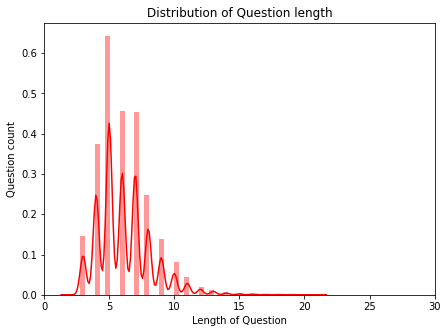

0 percentile value is 2.0
10 percentile value is 4.0
20 percentile value is 5.0
30 percentile value is 5.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 6.0
70 percentile value is 7.0
80 percentile value is 8.0
90 percentile value is 9.0
91 percentile value is 9.0
92 percentile value is 9.0
93 percentile value is 9.0
94 percentile value is 10.0
95 percentile value is 10.0
96 percentile value is 10.0
97 percentile value is 11.0
98 percentile value is 11.0
99 percentile value is 13.0
100 percentile value is 21.0


In [ ]:
plt.figure(figsize=(7,5))
sns.distplot(questions_len, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.xlim(0, 30)
plt.show()

for i in range(0,9):
    print(10*i,'percentile value is', np.percentile(questions_len,10*i))

for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(questions_len,90+i))

### Answers features

In [ ]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(answers_train)

print("%d answers classes found." % len(labelencoder.classes_))

58 answers classes found.


# Create Datasets

In [ ]:
def get_answers_matrix(answers, encoder):

	y = encoder.transform(answers) 
	nb_classes = encoder.classes_.shape[0]
	Y = utils.to_categorical(y, nb_classes)
	return Y

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size= 0.25,random_state=42)

TRAIN_INDEX, VAL_INDEX = list(sss.split(images_train, answers_train))[-1]

images_list_tr, images_list_val = np.array(images_train)[TRAIN_INDEX.astype(int)], np.array(images_train)[VAL_INDEX.astype(int)]
print("Images splitted: %d for training, %d for validation." % (len(images_list_tr), len(images_list_val)))

questions_tr, questions_val = question_data_train[TRAIN_INDEX], question_data_train[VAL_INDEX]
print("Questions splitted: %d for training, %d for validation." % (len(questions_tr), len(questions_val)))

answers_matrix = get_answers_matrix(answers_train, labelencoder)
answers_tr, answers_val = answers_matrix[TRAIN_INDEX], answers_matrix[VAL_INDEX]
print("Answers splitted: %d for training, %d for validation." % (len(answers_tr), len(answers_val)))


Images splitted: 44124 for training, 14708 for validation.
Questions splitted: 44124 for training, 14708 for validation.
Answers splitted: 44124 for training, 14708 for validation.


In [ ]:
def map_func(img_name, ques, ans):
    img_name = img_name.decode("utf-8")
    img_path = img_name.replace('Images','features')
    img_path = img_path.replace('png','npy')
    img_tensor = np.load(img_path)
    return img_tensor, ques, ans

In [ ]:
BUFFER_SIZE = 5000

dataset_tr = tf.data.Dataset.from_tensor_slices((images_list_tr, questions_tr, answers_tr))

dataset_tr = dataset_tr.map(lambda item1, item2, item3: tf.numpy_function(
    map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_tr = dataset_tr.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tr = dataset_tr.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((images_list_val, questions_val, answers_val))

dataset_val = dataset_val.map(lambda item1, item2, item3: tf.numpy_function(
    map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Build Model

### AttentionMaps Layer

In [ ]:
class AttentionMaps(tf.keras.layers.Layer):

  def __init__(self, dim_k, reg_value, **kwargs):
    super(AttentionMaps, self).__init__(**kwargs)

    self.dim_k = dim_k
    self.reg_value = reg_value

    self.Wv = Dense(self.dim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=2))
    self.Wq = Dense(self.dim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))

  def call(self, image_feat, ques_feat):

    C = tf.matmul(ques_feat, tf.transpose(image_feat, perm=[0,2,1])) 
    C = tf.keras.activations.tanh(C) 

    WvV = self.Wv(image_feat)                             
    WqQ = self.Wq(ques_feat)                              

    WqQ_C = tf.matmul(tf.transpose(WqQ, perm=[0,2,1]), C) 
    WqQ_C = tf.transpose(WqQ_C, perm =[0,2,1])            

    WvV_C = tf.matmul(tf.transpose(WvV, perm=[0,2,1]), tf.transpose(C, perm=[0,2,1]))  
                        
    WvV_C = tf.transpose(WvV_C, perm =[0,2,1])           

    H_v = WvV + WqQ_C                                     
    H_v = tf.keras.activations.tanh(H_v)                

    H_q = WqQ + WvV_C                                     
    H_q = tf.keras.activations.tanh(H_q)                  
        
    return [H_v, H_q]                                     
  
  def get_config(self):
 
    config = {
        'dim_k': self.dim_k,
        'reg_value': self.reg_value
    }
    base_config = super(AttentionMaps, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


In [ ]:
layer = AttentionMaps(64, 0.001)
print(layer.get_config())

{'name': 'attention_maps', 'trainable': True, 'dtype': 'float32', 'dim_k': 64, 'reg_value': 0.001}


### ContextVector Layer

In [ ]:
class ContextVector(tf.keras.layers.Layer):

  def __init__(self, reg_value, **kwargs):
    super(ContextVector, self).__init__(**kwargs)

    self.reg_value = reg_value

    self.w_hv = Dense(1, activation='softmax',\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
    self.w_hq = Dense(1, activation='softmax',\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5)) 
    

  def call(self, image_feat, ques_feat, H_v, H_q):
  
    a_v = self.w_hv(H_v)                              
    a_q = self.w_hq(H_q)                               

    v = a_v * image_feat                              
    v = tf.reduce_sum(v, 1)                           

    q = a_q * ques_feat                               
    q = tf.reduce_sum(q, 1)                          

    return [v, q]

  def get_config(self):

    config = {
        'reg_value': self.reg_value
    }
    base_config = super(ContextVector, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
layer = ContextVector(0.001)
print(layer.get_config())

{'name': 'context_vector', 'trainable': True, 'dtype': 'float32', 'reg_value': 0.001}


### PhraseLevelFeatures Layer

In [ ]:
class PhraseLevelFeatures(tf.keras.layers.Layer):
 
  def __init__(self, dim_d, **kwargs):
    super(PhraseLevelFeatures, self).__init__(**kwargs)
    
    self.dim_d = dim_d
    
    self.conv_unigram = Conv1D(self.dim_d, kernel_size=1, strides=1,\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=6)) 
    self.conv_bigram =  Conv1D(self.dim_d, kernel_size=2, strides=1, padding='same',\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7)) 
    self.conv_trigram = Conv1D(self.dim_d, kernel_size=3, strides=1, padding='same',\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=8)) 


  def call(self, word_feat):
 
    x_uni = self.conv_unigram(word_feat)                  

    x_bi  = self.conv_bigram(word_feat)                    

    x_tri = self.conv_trigram(word_feat)                  

    x = tf.concat([tf.expand_dims(x_uni, -1),\
                    tf.expand_dims(x_bi, -1),\
                    tf.expand_dims(x_tri, -1)], -1)       
    x = tf.reduce_max(x, -1)                                

    return x

  def get_config(self):
 
    config = {
        'dim_d': self.dim_d
    }
    base_config = super(PhraseLevelFeatures, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
layer = PhraseLevelFeatures(32)

print(layer.get_config())

{'name': 'phrase_level_features', 'trainable': True, 'dtype': 'float32', 'dim_d': 32}


### Model Architecture

In [ ]:
layer = None
new_layer = None

In [ ]:
def build_model(num_answers, max_seq_len, vocab_size, dim_d, dim_k, l_rate, d_rate, reg_value):
    """
    Defines the Keras model.

    Arguments
    ----------
    max_answers : Number of output targets of the model.
    max_seq_len : Length of input sequences
    vocab_size  : Size of the vocabulary, i.e. maximum integer index + 1.
    dim_d       : Hidden dimension
    dim_k       : Hidden attention dimension
    l_rate      : Learning rate for the model
    d_rate      : Dropout rate
    reg_value   : Regularization value

    Returns
    ----------
    Returns the Keras model.
    """

    image_input = Input(shape=(60, 512, ), name='Image_Input')
    ques_input = Input(shape=(max_seq_len, ), name='Question_Input')

    image_feat = Dense(dim_d, activation=None, name='Image_Feat_Dense',\
                            kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1))(image_input)
    image_feat = Dropout(d_rate, seed=1)(image_feat)

    ques_feat_w = Embedding(input_dim=vocab_size, output_dim=dim_d, input_length=max_seq_len,\
                            mask_zero=True)(ques_input)
    
    Hv_w, Hq_w = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Word')(image_feat, ques_feat_w)
    v_w, q_w = ContextVector(reg_value, name='ContextVector_Word')(image_feat, ques_feat_w, Hv_w, Hq_w)
    feat_w = tf.add(v_w,q_w)
    h_w = Dense(dim_d, activation='tanh', name='h_w_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=13))(feat_w)

    ques_feat_p = PhraseLevelFeatures(dim_d, name='PhraseLevelFeatures')(ques_feat_w)

    Hv_p, Hq_p = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Phrase')(image_feat, ques_feat_p)
    v_p, q_p = ContextVector(reg_value, name='ContextVector_Phrase')(image_feat, ques_feat_p, Hv_p, Hq_p)
    feat_p = concatenate([tf.add(v_p,q_p), h_w], -1) 
    h_p = Dense(dim_d, activation='tanh', name='h_p_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=14))(feat_p)

    ques_feat_s = LSTM(dim_d, return_sequences=True, input_shape=(None, max_seq_len, dim_d),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(ques_feat_p)

    Hv_s, Hq_s = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Sent')(image_feat, ques_feat_s)
    v_s, q_s = ContextVector(reg_value, name='ContextVector_Sent')(image_feat, ques_feat_p, Hv_s, Hq_s)
    feat_s = concatenate([tf.add(v_s,q_s), h_p], -1) 
    h_s = Dense(2*dim_d, activation='tanh', name='h_s_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=15))(feat_s)

    z   = Dense(2*dim_d, activation='tanh', name='z_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(h_s)
    z   = Dropout(d_rate, seed=16)(z)

    result = Dense(num_answers, activation='softmax')(z)

    model = Model(inputs=[image_input, ques_input], outputs=result)

    return model

In [ ]:
vocab_size  = len(tok.word_index) + 1

dim_d       = 512
dim_k       = 256
l_rate      = 1e-4
d_rate      = 0.5
reg_value   = 0.01
  
model = build_model(num_answers, MAX_QUESTIONS_LEN, vocab_size, dim_d, dim_k, l_rate, d_rate, reg_value)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 60, 512)]    0                                            
__________________________________________________________________________________________________
Image_Feat_Dense (Dense)        (None, 60, 512)      262656      Image_Input[0][0]                
__________________________________________________________________________________________________
Question_Input (InputLayer)     [(None, 21)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 60, 512)      0           Image_Feat_Dense[0][0]           
______________________________________________________________________________________________

# Train Model

### Configure Training

In [ ]:
training_dir = dataset_dir / 'temps'
if not os.path.exists(training_dir):
    os.mkdir(training_dir)

checkpoints_dir = training_dir / ('checkpoint_'+str(l_rate)+"_"+str(dim_k))
if not os.path.exists(checkpoints_dir):
    os.mkdir(checkpoints_dir)

train_log_dir = training_dir / 'logs' / (str(l_rate)+"_"+str(dim_k)) / 'train'
val_log_dir   = training_dir / 'logs'/ (str(l_rate)+"_"+str(dim_k)) / 'validation'

In [ ]:
EPOCHS          = 50

steps_per_epoch = int(np.ceil(len(images_list_tr)/BATCH_SIZE))
boundaries      = [EPOCHS * steps_per_epoch]
values          = [l_rate, l_rate / 10]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer        = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

loss_object      = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, model=model)

manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=3)

In [ ]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

train_score = F1Score(num_classes=num_answers, average='micro', name='train_score')
val_score = F1Score(num_classes=num_answers, average='micro', name='val_score')

In [ ]:
train_summary_writer = tf.summary.create_file_writer(str(train_log_dir))
val_summary_writer = tf.summary.create_file_writer(str(val_log_dir))

### Restore Training Status

In [ ]:
SAVE_CKPT_FREQ = 5

if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint)
    print("Restored from {}".format(manager.latest_checkpoint))
    START_EPOCH = int(manager.latest_checkpoint.split('-')[-1]) * SAVE_CKPT_FREQ
    print("Resume training from epoch: {}".format(START_EPOCH))
else:
    print("Initializing from scratch")
    START_EPOCH = 0

Restored from /content/VQA_Dataset/temps/checkpoint_0.0001_256/ckpt-4
Resume training from epoch: 20


### Training

In [ ]:
def train_step(model, img, ques, ans, optimizer):
  with tf.GradientTape() as tape:
    predictions = model([img, ques], training=True)
    loss = loss_object(ans, predictions)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_score(ans, predictions)

  grads_ = list(zip(grads, model.trainable_variables))
  return grads_

def test_step(model, img, ques, ans):
  predictions = model([img, ques])
  loss = loss_object(ans, predictions)

  val_loss(loss)
  val_score(ans, predictions)

In [ ]:
for epoch in range(START_EPOCH, EPOCHS):

  start = time.time()

  for img, ques, ans in (dataset_tr):
    grads = train_step(model, img, ques, ans, optimizer)

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('f1_score', train_score.result(), step=epoch)
    for var in model.trainable_variables:
        tf.summary.histogram(var.name, var, step=epoch)
    for grad, var in grads:
        tf.summary.histogram(var.name + '/gradient', grad, step=epoch)

  for img, ques, ans in (dataset_val):
    test_step(model, img, ques, ans)
  
  with val_summary_writer.as_default():
    tf.summary.scalar('loss', val_loss.result(), step=epoch)
    tf.summary.scalar('f1_score', val_score.result(), step=epoch)
  
  template = 'Epoch {}, loss: {:.4f}, f1_score: {:.4f}, val loss: {:.4f}, val f1_score: {:.4f}, time: {:.0f} sec'
  print(template.format(epoch + 1,
                         train_loss.result(), 
                         train_score.result(),
                         val_loss.result(), 
                         val_score.result(),
                         (time.time() - start)))

  train_loss.reset_states()
  train_score.reset_states()
  val_loss.reset_states()
  val_score.reset_states()

  ckpt.step.assign_add(1)
  if int(ckpt.step) % SAVE_CKPT_FREQ == 0:
      manager.save()
      print('Saved checkpoint.')

Epoch 21, loss: 2.2812, f1_score: 0.3612, val loss: 2.1987, val f1_score: 0.3771, time: 61 sec
Epoch 22, loss: 2.2416, f1_score: 0.3649, val loss: 2.1739, val f1_score: 0.3829, time: 61 sec
Epoch 23, loss: 2.2158, f1_score: 0.3706, val loss: 2.1486, val f1_score: 0.3840, time: 61 sec
Epoch 24, loss: 2.2018, f1_score: 0.3701, val loss: 2.1566, val f1_score: 0.3823, time: 60 sec
Epoch 25, loss: 2.1925, f1_score: 0.3746, val loss: 2.1353, val f1_score: 0.3824, time: 60 sec
Saved checkpoint.
Epoch 26, loss: 2.1803, f1_score: 0.3717, val loss: 2.1281, val f1_score: 0.3868, time: 61 sec
Epoch 27, loss: 2.1665, f1_score: 0.3742, val loss: 2.1193, val f1_score: 0.3824, time: 60 sec
Epoch 28, loss: 2.1429, f1_score: 0.3725, val loss: 2.0844, val f1_score: 0.3846, time: 60 sec
Epoch 29, loss: 2.1066, f1_score: 0.3763, val loss: 2.0581, val f1_score: 0.3911, time: 60 sec
Epoch 30, loss: 2.0624, f1_score: 0.3825, val loss: 1.9549, val f1_score: 0.4024, time: 60 sec
Saved checkpoint.
Epoch 31, loss

# Evaluation

### Create test dataset

In [ ]:
tr_images = np.array(images_train)[TRAIN_INDEX.astype(int)]
val_images = np.array(images_train)[VAL_INDEX.astype(int)]

tr_questions = np.array(questions_train_processed)[TRAIN_INDEX.astype(int)]
val_questions = np.array(questions_train_processed)[VAL_INDEX.astype(int)]

tr_answers = np.array(answers_train)[TRAIN_INDEX.astype(int)]
val_answers = np.array(answers_train)[VAL_INDEX.astype(int)]

In [ ]:
def map_func_eval(img_name, ques):
    img_name = img_name.decode("utf-8")
    img_path = img_name.replace('Images','features')
    img_path = img_path.replace('png','npy')
    img_tensor = np.load(img_path)
    return img_tensor, ques

In [ ]:
dataset_tr_eval = tf.data.Dataset.from_tensor_slices((images_list_tr, questions_tr))

dataset_tr_eval = dataset_tr_eval.map(lambda item1, item2: tf.numpy_function(
    map_func_eval, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_tr_eval = dataset_tr_eval.batch(BATCH_SIZE)

dataset_val_eval = tf.data.Dataset.from_tensor_slices((images_list_val, questions_val))

dataset_val_eval = dataset_val_eval.map(lambda item1, item2: tf.numpy_function(
    map_func_eval, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_val_eval = dataset_val_eval.batch(BATCH_SIZE)

### Predict answers

In [ ]:
def preprocess_data(image_id, question):

  features = np.load(str(features_dir / (image_id+'.npy')))
  features = np.expand_dims(features,axis=0)
  
  processed_question = process_sentence(question)
  tok.fit_on_texts(processed_question)
  processed_question = [processed_question]
  processed_question = tok.texts_to_sequences(processed_question)
  processed_question = sequence.pad_sequences(processed_question, maxlen=MAX_QUESTIONS_LEN, padding='post')

  return features,processed_question

def predict(image_feature, processed_question):
  answer = model([image_feature,processed_question])
  answer = tf.argmax(answer, axis=1, output_type=tf.int32)
  answer = (labelencoder.inverse_transform(answer))
  return answer

In [ ]:
test_questions = json.load(open(dataset_dir / 'test_questions.json', 'r'))

labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [ ]:
results = {}

for key, value in tqdm(test_questions.items()):
    image_features, processed_question = preprocess_data(value['image_id'],value['question'])
    answer = predict(image_features,processed_question)
    
    results[key] = labels_dict.get(answer[0])

100%|██████████| 6372/6372 [03:23<00:00, 31.34it/s]


### Create CSV

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

create_csv(results, str(dataset_dir))